In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

train_path = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/UNSW_NB15_training-set.csv")
test_path = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/UNSW_NB15_testing-set.csv")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = df_train.drop(columns='label')
X_train = df_train.drop(columns='attack_cat')
y_train = df_train['attack_cat']

X_test = df_test.drop(columns='label')
X_test = df_test.drop(columns='attack_cat')
y_test = df_test['attack_cat']

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

pipeline_RFC = Pipeline([
    ('preprocessing', preprocessor),
    ('select', SelectFromModel(RandomForestClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ), threshold=0.005)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=150,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ))
])

pipeline_RFC.fit(X_train, y_train)
y_pred = pipeline_RFC.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      Analysis       0.14      0.20      0.16       677
      Backdoor       0.02      0.15      0.03       583
           DoS       0.23      0.12      0.16      4089
      Exploits       0.86      0.54      0.67     11132
       Fuzzers       0.83      0.66      0.74      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.94      1.00      0.97     37000
Reconnaissance       0.84      0.84      0.84      3496
     Shellcode       0.22      0.92      0.35       378
         Worms       0.18      0.77      0.30        44

      accuracy                           0.84     82332
     macro avg       0.53      0.62      0.52     82332
  weighted avg       0.88      0.84      0.85     82332



In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_for_RFC = preprocessor.fit_transform(X_train)
rf.fit(X_train_for_RFC, y_train)

selector = SelectFromModel(rf, threshold='mean')
selector.fit(X_train_for_RFC, y_train)

X_train_reduced = selector.transform(X_train_for_RFC)
X_test_reduced = selector.transform(X_test)

C:\Users\maxpd\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


ValueError: X has 44 features, but SelectFromModel is expecting 196 features as input.

In [17]:
low_fscores = ['Analysis', 'Backdoor', 'DoS', 'Worms']
y_train = y_train.replace(low_fscores, 'Other')
y_test = y_test.replace(low_fscores, 'Other')
pipeline_RFC.fit(X_train, y_train)
y_pred = pipeline_RFC.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      Exploits       0.86      0.55      0.67     11132
       Fuzzers       0.93      0.62      0.74      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.94      1.00      0.97     37000
         Other       0.47      0.74      0.57      5393
Reconnaissance       0.83      0.84      0.84      3496
     Shellcode       0.21      0.89      0.33       378

      accuracy                           0.88     82332
     macro avg       0.75      0.80      0.73     82332
  weighted avg       0.90      0.88      0.88     82332



Train Accuracy: 0.8649
Test Accuracy: 0.8772


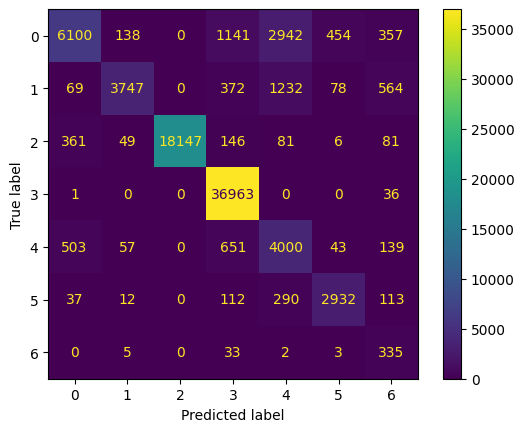

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
pipeline_RFC.fit(X_train, y_train)
prediction_train = pipeline_RFC.predict(X_train)
prediction_test = pipeline_RFC.predict(X_test)
accuracy_train = accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
cm = confusion_matrix(y_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [19]:
from sklearn.model_selection import cross_val_score
cv_RFC = cross_val_score(pipeline_RFC, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1)
print('Cross-Validation: ', cv_RFC)
print('Mean CV Accuracy: ', cv_RFC.mean())

Cross-Validation:  [0.86218598 0.86126953 0.85964412 0.86175431 0.8633512 ]
Mean CV Accuracy:  0.8616410277975579


In [20]:
print('hello')

hello


Training KNN models: 100%|█████████████████| 38/38 [55:10<00:00, 87.12s/it]


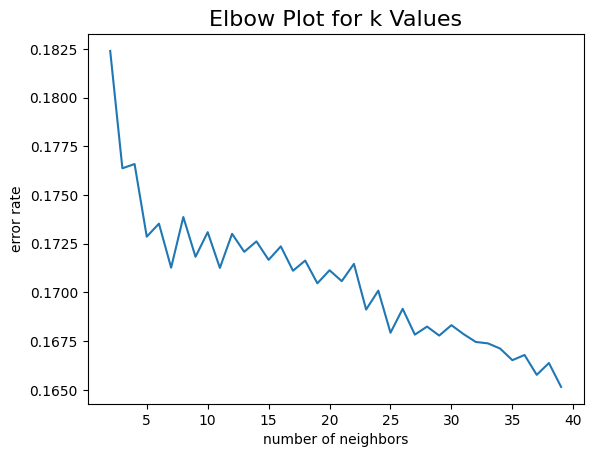

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),
    #('select', SelectFromModel(RandomForestClassifier(), threshold = 'median')),
    ('classifier', KNeighborsClassifier())
])
k_vals = []
error_rates = []

for i in tqdm(range(2, 40), desc="Training KNN models"):
    pipeline_KNN.set_params(classifier__n_neighbors = i)
    pipeline_KNN.fit(X_train, y_train)
    error_rates.append(
        1 - accuracy_score(y_test, pipeline_KNN.predict(X_test))
    )
    k_vals.append(i)

plt.figure()
plt.title("Elbow Plot for k Values", fontsize=16)
plt.plot(k_vals, error_rates, linestyle='-')
plt.xlabel("number of neighbors")
plt.ylabel("error rate")
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder
pipeline_KNN.set_params(classifier__n_neighbors = 40)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipeline_KNN.fit(X_train, y_train_encoded)
y_pred_knn = pipeline_KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
print('Accuracy:', accuracy_knn)

Accuracy: 0.8748238837875917


In [ ]:
print('hello')

In [ ]:
prediction_train = pipeline_KNN.predict(X_train)
prediction_test = pipeline_KNN.predict(X_test)
accuracy_train = accuracy_score(y_train_encoded, prediction_train)
accuracy_test = accuracy_score(y_test_encoded, prediction_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
cm = confusion_matrix(y_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test_encoded, y_pred_knn))

In [ ]:
selector = SelectFromModel(pipeline_RFC, threshold = 'mean')
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)